MONTE CARLO SIMULATION

In [18]:
#### Lib Imports _ Please select a kernel with the latest version of olca IPC API  [TBVerified and replicated]
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
import random as rand
from datetime import datetime, timedelta
import statistics as stats
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.stats as stat
#import olca as ipc (Old_version of Ipc API)
import olca_ipc as ipc
import olca_schema as o
import plotly.graph_objects as go
import nbformat as nb



from typing import Callable
###########################################################
client = ipc.Client(8080)
# OpenLCA IPC server Port
###########################################################

In [29]:
print("\nProduct Systems :")
for group_PS in client.get_all(o.ProductSystem):
    print(f"{group_PS.name} : {group_PS.target_amount} {group_PS.target_unit.name} ___ Version : {group_PS.version} Last Updt : {group_PS.last_change}" )

    #### CHeck all the impact model available
print("\nImpact Methods")
methods = client.get_descriptors(o.ImpactMethod)
for method in methods: print(f"{method.name} :: {method.id}")


Product Systems :
Power System : 1.0 Item(s) ___ Version : 00.00.000 Last Updt : 2023-11-27T15:41:26.156Z
Power System Assembly & Qualification : 1.0 Item(s) ___ Version : 00.00.000 Last Updt : 2023-11-28T08:08:13.571Z

Impact Methods
Tests :: ac3cd8bd-3c4a-425c-a25c-63b3eede91f8


In [90]:
print("run iteration 1")
## Direct Selection 
LCA_Prod_syst = client.find (o.ProductSystem, name = "Power System Assembly & Qualification")
LCA_Impact_method= client.find(o.ImpactMethod, name="Tests")
print (f"LCA Calculation of {LCA_Prod_syst.name} using the {LCA_Impact_method.name} assessment method\n")

result_sim = client.simulate(
    o.CalculationSetup(
        target= LCA_Prod_syst,
        impact_method=LCA_Impact_method,
    )
)
### Check if Any error
state = result_sim.get_state()
if state.error:
    print(f"calculation failed: {state.error}")
    exit(-1)

result_sim.wait_until_ready()
print(f"result id: {state.id}")

print("\n Results")
indicators = []
impact_cat_dict = {}
for i in result_sim.get_total_impacts():
    assert i.impact_category
    indicators.append (i.impact_category)
    impact_cat_dict[i.impact_category.name] = i.impact_category.ref_unit
    print(f"{i.impact_category.name} {i.amount} {i.impact_category.ref_unit}   {i.impact_category.id}")


run iteration 1
LCA Calculation of Power System Assembly & Qualification using the Tests assessment method

result id: ff686ca8-6108-4b55-a2b3-c2c02a1cf605

 Results
Waste Production 156.17177188110696 kg   c1817abf-82fe-4274-ba44-9f2d2b1aeadd
Global Warming 3073.851683444077 kg C02-eq   709c4cdf-619c-4265-9f0f-bfa1fa895474
Abiotic Ressource depletion 1257.1308020311214 kg   c9021409-18ea-4c68-93b5-8434afe8b515


In [92]:
# get the result for some indicator from the first iteration
#indicator = client.find(o.ImpactCategory,name="Global Warming")

#indicator = client.get(o.ImpactCategory,"ca2d7af7-3e55-34f9-8ab7-b0c28ca7ddae")
val = lambda: [result_sim.get_total_impact_value_of(indicator).amount for indicator in indicators]

xs: list[float] = [val()]

print (xs)

[[156.17177188110696, 3073.851683444077, 1257.1308020311214]]


In [127]:
# collect the values from 4999 more iterations
for i in range(0, 499):
    if (i % 100) == 0 : 
        print(f"run iteration {i+2}")
    result_sim.simulate_next()
    result_sim.wait_until_ready()
    xs.append(val())

Monte_Carlo_results = pd.DataFrame(xs,columns=[indicator.name for indicator in indicators])
print (Monte_Carlo_results)

run iteration 2
run iteration 102
run iteration 202
run iteration 302
run iteration 402
      Waste Production  Global Warming  Abiotic Ressource depletion
0           156.171772     3073.851683                  1257.130802
1           154.704881     3177.746366                  1261.102781
2           170.663524     3446.231991                  1381.784648
3           142.422258     2982.203384                  1163.888556
4           163.321464     3324.728654                  1315.457989
...                ...             ...                          ...
1573        154.045213     3274.339365                  1265.932057
1574        157.788617     3280.455073                  1269.064535
1575        161.726030     3409.982050                  1311.746757
1576        160.561139     3196.110561                  1286.783477
1577        157.393010     3346.966914                  1276.671763

[1578 rows x 3 columns]


95% Confidence Interval: (148.99485803503504, 167.66836470161323) Mean  158.33161136832413


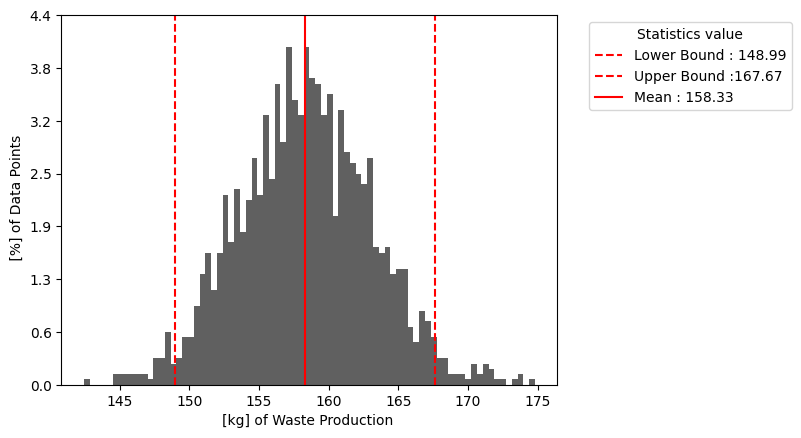

95% Confidence Interval: (3083.2831876985924, 3486.20879339825) Mean  3284.745990548421


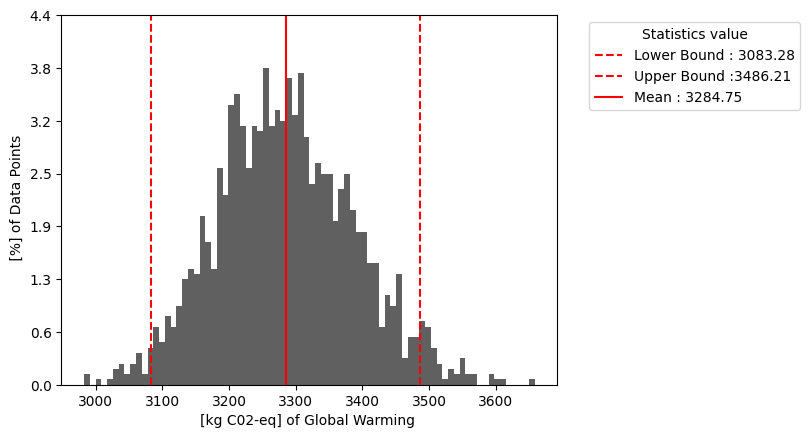

95% Confidence Interval: (1209.5921502315803, 1358.3750359372368) Mean  1283.9835930844085


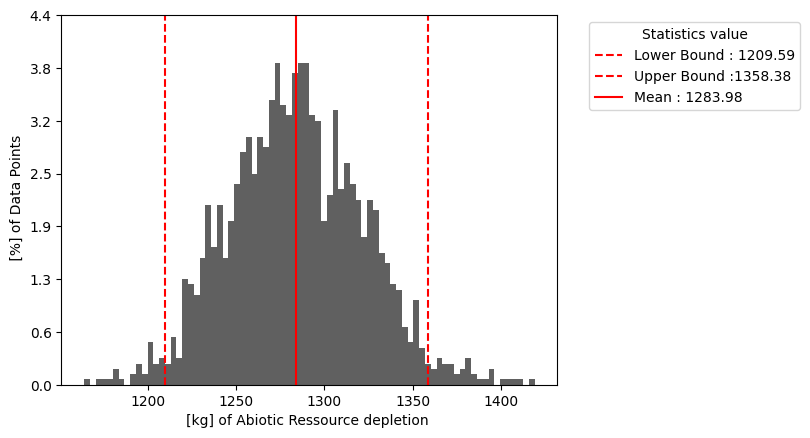

                             Lower Bound  Upper Bound         Mean
Waste Production              148.994858   167.668365   158.331611
Global Warming               3083.283188  3486.208793  3284.745991
Abiotic Ressource depletion  1209.592150  1358.375036  1283.983593


In [143]:
Stat = []
for indicator in indicators : 
    data = Monte_Carlo_results[indicator.name]
    confidence_interval = stat.t.interval(0.95, len(data) - 1, loc=np.mean(data), scale=stats.stdev(data))

    plt.hist(data,bins=len(data)//20,color='#606060')
    locs, _ = plt.yticks() 
    plt.yticks(locs,np.round(locs/len(data)*100,1))

    # Highlight the mean & Confident interval
    plt.axvline(x=confidence_interval[0], color='r', linestyle='--', label='Lower Bound')
    plt.axvline(x=confidence_interval[1], color='r', linestyle='--', label='Upper Bound')
    plt.axvline(x=np.mean(data), color='r', linestyle='-', label='Mean')

    # Add labels and legend
    plt.xlabel(f'[{indicator.ref_unit}] of {indicator.name} ')
    plt.ylabel(" [%] of Data Points")
    plt.legend([f'Lower Bound : {confidence_interval[0] :.2f}',f'Upper Bound :{confidence_interval[1]:.2f}',f'Mean : {np.mean(data) :.2f}'],title='Statistics value', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()

    Stat.append([confidence_interval[0],confidence_interval[1],np.mean(data)])

Statistical_results = pd.DataFrame(Stat,columns=['Lower Bound','Upper Bound','Mean'], index=[indicator.name for indicator in indicators])
print(Statistical_results)